In [3]:
#In this script, the models trained from Jan 2017- Jun 2019 from Prophet,XGBoost and ARIMA are presented:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
import imageio
import os
from fbprophet import Prophet

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests

from pmdarima import auto_arima # for determining ARIMA orders
%matplotlib inline
#ignore harmless warnings
import warnings 
warnings.filterwarnings("ignore")



ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [4]:
df=pd.read_csv("mid-gas-2017-2019.csv",index_col=[0], parse_dates=[0])
df.head(3)

,Price,Volume,Settlement Period,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,SAP,EU_ETS,Gas
datetime,,,,,,,,,,,,,,
2017-01-01 00:00:00,44.90,505.00,1,0.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832
2017-01-01 00:30:00,47.13,559.15,2,0.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832
2017-01-01 01:00:00,45.62,649.35,3,1.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832


In [5]:
df_INDO=pd.read_csv('INDO-2017-2019.csv',index_col=[0],parse_dates=[0])

df_INDO.head(3)

,Settlement_Period,INDO
datetime,,
2017-01-01 00:00:00,1,27239
2017-01-01 00:30:00,2,27814
2017-01-01 01:00:00,3,27453


In [6]:
df_ITSDO=pd.read_csv('ITSDO-2017-2019.csv',index_col=[0],parse_dates=[0])

df_ITSDO.head(3)

,Settlement Period,ITSDO
datetime,,
2017-01-01 00:00:00,1,27949
2017-01-01 00:30:00,2,28435
2017-01-01 01:00:00,3,28165


In [7]:
df=pd.merge(df,df_INDO['INDO'], how='inner', left_index=True, right_index=True)

In [8]:
df=pd.merge(df,df_ITSDO['ITSDO'], how='inner', left_index=True, right_index=True)

In [9]:
print(df.shape)
df.tail()


(43391, 16)


,Price,Volume,Settlement Period,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,SAP,EU_ETS,Gas,INDO,ITSDO
datetime,,,,,,,,,,,,,,,,
2019-07-01 21:30:00,55.31,1423.25,44,21.0,Mon,3.0,Jul,2019.0,182.0,1.0,27.0,9.05,4.338429,16.701429,27987,28498
2019-07-01 22:00:00,55.69,1429.55,45,22.0,Mon,3.0,Jul,2019.0,182.0,1.0,27.0,9.05,4.338429,16.701429,27380,27914
2019-07-01 22:30:00,46.23,1572.85,46,22.0,Mon,3.0,Jul,2019.0,182.0,1.0,27.0,9.05,4.338429,16.701429,26245,26760
2019-07-01 23:00:00,34.96,917.05,47,23.0,Mon,3.0,Jul,2019.0,182.0,1.0,27.0,9.05,4.338429,16.701429,24499,25015
2019-07-01 23:30:00,43.85,828.65,48,23.0,Mon,3.0,Jul,2019.0,182.0,1.0,27.0,9.05,4.338429,16.701429,22940,23452


In [10]:
#Exploratory Data Analysis
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Price,Volume,Settlement Period,hour,quarter,year,dayofyear,dayofmonth,weekofyear,SAP,EU_ETS,Gas,INDO,ITSDO
Price,1,0.170764,0.254346,0.254757,0.129036,0.105262,0.12706,-0.0196076,0.126961,0.60998,0.187125,0.622183,0.504496,0.495327
Volume,0.170764,1,0.517171,0.515865,-0.0332379,0.111798,-0.0325621,-0.0255877,-0.0318369,0.0412474,0.0763435,0.0551253,0.389849,0.364098
Settlement Period,0.254346,0.517171,1,0.999347,-0.00160304,0.00135438,-0.00135778,0.000690264,-0.00136079,0.000475607,0.000735156,0.00060595,0.468902,0.424307
hour,0.254757,0.515865,0.999347,1,-0.00158387,0.00134185,-0.00134014,0.000695934,-0.0013431,0.000426464,0.000730731,0.000558005,0.46932,0.424684
quarter,0.129036,-0.0332379,-0.00160304,-0.00158387,1,-0.290439,0.9673,0.0126524,0.956788,0.17756,0.0549731,0.181188,-0.156743,-0.147701
year,0.105262,0.111798,0.00135438,0.00134185,-0.290439,1,-0.282519,-0.00897423,-0.28111,0.00750488,0.900316,0.191672,-0.0202761,-0.0358059
dayofyear,0.12706,-0.0325621,-0.00135778,-0.00134014,0.9673,-0.282519,1,0.0960667,0.986441,0.179166,0.0729592,0.186412,-0.163689,-0.156328
dayofmonth,-0.0196076,-0.0255877,0.000690264,0.000695934,0.0126524,-0.00897423,0.0960667,1,0.0830318,-0.0544779,0.0279553,-0.0464094,-0.0391771,-0.03877
weekofyear,0.126961,-0.0318369,-0.00136079,-0.0013431,0.956788,-0.28111,0.986441,0.0830318,1,0.180045,0.0698079,0.186606,-0.160023,-0.152631
SAP,0.60998,0.0412474,0.000475607,0.000426464,0.17756,0.00750488,0.179166,-0.0544779,0.180045,1,0.106765,0.979025,0.186568,0.202223


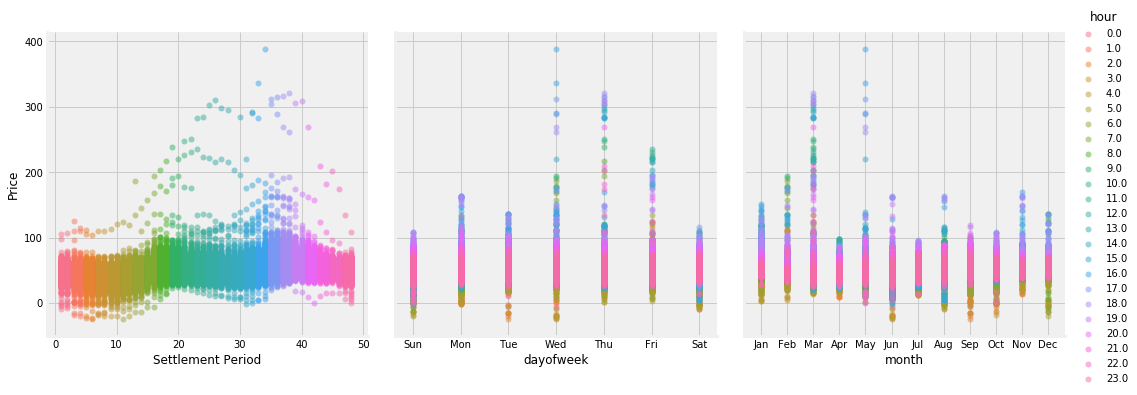

In [12]:
sns.pairplot(df,
             hue = 'hour',
             x_vars=['Settlement Period','dayofweek','month'],
             y_vars='Price',
             height=5,
             plot_kws={'alpha':0.5, 'linewidth':0}
            )
plt.show()

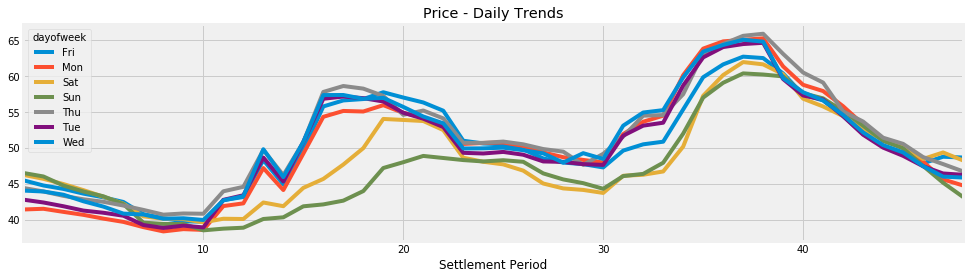

In [13]:
df.pivot_table(index=df['Settlement Period'], 
                     columns='dayofweek', 
                     values='Price',
                     aggfunc='mean').plot(figsize=(15,4),
                     title='Price - Daily Trends')
plt.show()

In [16]:
#Splitting the data:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

def limit(data, frm, to):
    return data[(data.index>=frm)&(data.index<to)]

In [17]:
df.sort_index(inplace=True)

In [18]:
#Price test
t = df.Price.copy()
t = t.drop(t.index[t.index.duplicated()])
freq_index = pd.date_range(start=t.index[0], end=t.index[-1], freq='30T')
constructed = pd.Series(index=freq_index, name='Price')
constructed.update(t)
constructed.interpolate(inplace=True)


In [80]:
train = limit(constructed, '2017-01-01', '2019-06-15')
test  = limit(constructed, '2019-06-15', '2019-07-01')
print(train.shape)
print(test.shape)

(42960,)
(768,)


In [20]:
#for INDO data
i = df.INDO.copy()
i = i.drop(i.index[i.index.duplicated()])
freq_index = pd.date_range(start=i.index[0], end=i.index[-1], freq='30T')
constructed_i = pd.Series(index=freq_index, name='INDO')
constructed_i.update(i)
constructed_i.interpolate(inplace=True)

In [81]:
train_indo = limit(constructed_i, '2017-01-01', '2019-06-15')
test_indo  = limit(constructed_i, '2019-06-15', '2019-07-01')
print(train_indo.shape)
print(test_indo.shape)

(42960,)
(768,)


In [22]:
#for ITSDO data
j = df.ITSDO.copy()
j = j.drop(j.index[j.index.duplicated()])
freq_index = pd.date_range(start=j.index[0], end=j.index[-1], freq='30T')
constructed_j = pd.Series(index=freq_index, name='ITSDO')
constructed_j.update(j)
constructed_j.interpolate(inplace=True)

In [82]:
train_itsdo = limit(constructed_j, '2017-01-01', '2019-06-15')
test_itsdo  = limit(constructed_j, '2019-06-15', '2019-07-01')
print(train_itsdo.shape)
print(test_itsdo.shape)

(42960,)
(768,)


In [24]:
#for gas series:
g = df.Gas.copy()
g = g.drop(g.index[g.index.duplicated()])
freq_index = pd.date_range(start=g.index[0], end=g.index[-1], freq='30T')
constructed_gas = pd.Series(index=freq_index, name='Gas')
constructed_gas.update(g)
constructed_gas.interpolate(inplace=True)


In [83]:
train_gas = limit(constructed_gas, '2017-01-01', '2019-06-15')
test_gas  = limit(constructed_gas, '2019-06-15', '2019-07-01')
train_gas.shape,test_gas.shape

((42960,), (768,))

In [26]:
train_gas.index
#sum(df.index.isin(train.index))

DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 00:30:00',
               '2019-01-01 01:00:00', '2019-01-01 01:30:00',
               '2019-01-01 02:00:00', '2019-01-01 02:30:00',
               '2019-01-01 03:00:00', '2019-01-01 03:30:00',
               '2019-01-01 04:00:00', '2019-01-01 04:30:00',
               ...
               '2019-06-14 19:00:00', '2019-06-14 19:30:00',
               '2019-06-14 20:00:00', '2019-06-14 20:30:00',
               '2019-06-14 21:00:00', '2019-06-14 21:30:00',
               '2019-06-14 22:00:00', '2019-06-14 22:30:00',
               '2019-06-14 23:00:00', '2019-06-14 23:30:00'],
              dtype='datetime64[ns]', length=7920, freq='30T')

In [27]:
train_=df[df.index.isin(train.index)].copy()
test_=df[df.index.isin(test.index)].copy()
train_.shape,test_.shape

((7810, 16), (768, 16))

In [28]:
train.head(),train_indo.head(),train_itsdo.head(),train_gas.head()

(2019-01-01 00:00:00    48.81
 2019-01-01 00:30:00    50.24
 2019-01-01 01:00:00    41.90
 2019-01-01 01:30:00    39.32
 2019-01-01 02:00:00    34.09
 Freq: 30T, Name: Price, dtype: float64, 2019-01-01 00:00:00    23712.0
 2019-01-01 00:30:00    24315.0
 2019-01-01 01:00:00    24037.0
 2019-01-01 01:30:00    23072.0
 2019-01-01 02:00:00    22204.0
 Freq: 30T, Name: INDO, dtype: float64, 2019-01-01 00:00:00    25183.0
 2019-01-01 00:30:00    25633.0
 2019-01-01 01:00:00    25384.0
 2019-01-01 01:30:00    24456.0
 2019-01-01 02:00:00    24255.0
 Freq: 30T, Name: ITSDO, dtype: float64, 2019-01-01 00:00:00    24.560535
 2019-01-01 00:30:00    24.560535
 2019-01-01 01:00:00    24.560535
 2019-01-01 01:30:00    24.560535
 2019-01-01 02:00:00    24.560535
 Freq: 30T, Name: Gas, dtype: float64)

In [29]:
df.index

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 00:30:00',
               '2017-01-01 01:00:00', '2017-01-01 01:30:00',
               '2017-01-01 02:00:00', '2017-01-01 02:30:00',
               '2017-01-01 03:00:00', '2017-01-01 03:30:00',
               '2017-01-01 04:00:00', '2017-01-01 04:30:00',
               ...
               '2019-07-01 19:00:00', '2019-07-01 19:30:00',
               '2019-07-01 20:00:00', '2019-07-01 20:30:00',
               '2019-07-01 21:00:00', '2019-07-01 21:30:00',
               '2019-07-01 22:00:00', '2019-07-01 22:30:00',
               '2019-07-01 23:00:00', '2019-07-01 23:30:00'],
              dtype='datetime64[ns]', name='datetime', length=43391, freq=None)

In [31]:
holidays= pd.read_csv("generated_holidays.csv")
holidays.head()

,ds,holiday,country,year
0,1995-01-01,Ano Nuevo [New Year's Day],AR,1995
1,1995-02-27,Dia de Carnaval [Carnival's Day],AR,1995
2,1995-02-28,Dia de Carnaval [Carnival's Day],AR,1995
3,1995-03-24,Dia Nacional de la Memoria por la Verdad y la ...,AR,1995
4,1995-04-02,Dia del Veterano y de los Caidos en la Guerra ...,AR,1995


In [36]:
holidays.drop(holidays[holidays['country'] !='UK'].index, inplace=True)

In [37]:
holidays.drop(holidays[holidays['year'] < 2017].index, inplace=True)

In [38]:
holidays.drop(holidays[holidays['year'] > 2020].index, inplace=True)

In [39]:
holidays.head(3)

,ds,holiday,country,year
79565,2017-01-01,New Year's Day,UK,2017
79566,2017-01-02,"New Year Holiday [Scotland], New Year's Day (O...",UK,2017
79567,2017-01-03,New Year Holiday [Scotland] (Observed),UK,2017


In [84]:
#The Prophet Model:
model_P = Prophet(weekly_seasonality=True,yearly_seasonality=True, daily_seasonality=True,holidays=holidays)
#model_P = Prophet()
#model_P.add_seasonality(name="monthly", period=30.5, fourier_order=5)
model_P.add_regressor('Gas')
#model_P.add_regressor('INDO')
#model_P.add_regressor('ITSDO')
model_P.fit(pd.DataFrame({'ds': train.index, 'y':train, 'Gas': train_gas}))
#model_P.fit(pd.DataFrame({'ds': train.index, 'y':train, 'Gas': train_gas, 'INDO': train_indo}))


In [85]:
#def populate_indo_val(dt):
 #   current_date=str(dt.date())
  #  return df[current_date]['INDO'][0]

#def populate_itsdo_val(dt):
 #   current_date=str(dt.date())
  #  return df[current_date]['ITSDO'][0]


def populate_gas_val(dt):
    current_date=str(dt.date())
    return df[current_date]['Gas'][0]


#df_train_test_data=df[df.index.isin(train.index.union(test.index))].copy()

future_dates = model_P.make_future_dataframe(periods=test.shape[0],freq='30T')
#future_dates['INDO']=future_dates['ds'].apply(populate_indo_val)
#future_dates['ITSDO']=future_dates['ds'].apply(populate_itsdo_val)
future_dates['Gas']=future_dates['ds'].apply(populate_gas_val)
results_P = model_P.predict(future_dates)
forecast_P = results_P.set_index('ds').yhat

In [86]:
results_P[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15) #prediction values

,ds,yhat,yhat_lower,yhat_upper
43713,2019-06-30 16:30:00,47.565858,33.975424,59.841547
43714,2019-06-30 17:00:00,50.000274,37.610266,63.838813
43715,2019-06-30 17:30:00,51.875181,39.106423,66.448319
43716,2019-06-30 18:00:00,52.951985,39.734375,67.038535
43717,2019-06-30 18:30:00,53.098816,40.571840,66.386967
43718,2019-06-30 19:00:00,52.313717,38.990722,66.265261
43719,2019-06-30 19:30:00,50.724176,37.825752,64.384709
43720,2019-06-30 20:00:00,48.562364,35.219042,62.798149
43721,2019-06-30 20:30:00,46.120744,33.092098,58.965854
43722,2019-06-30 21:00:00,43.697162,30.271743,56.907363


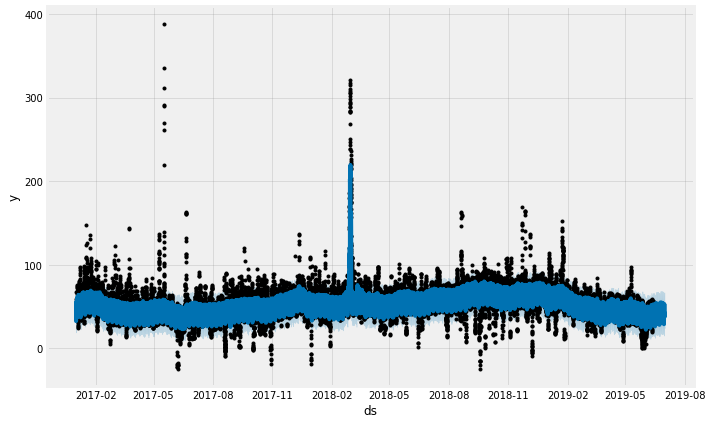

In [87]:
fig=model_P.plot(results_P)

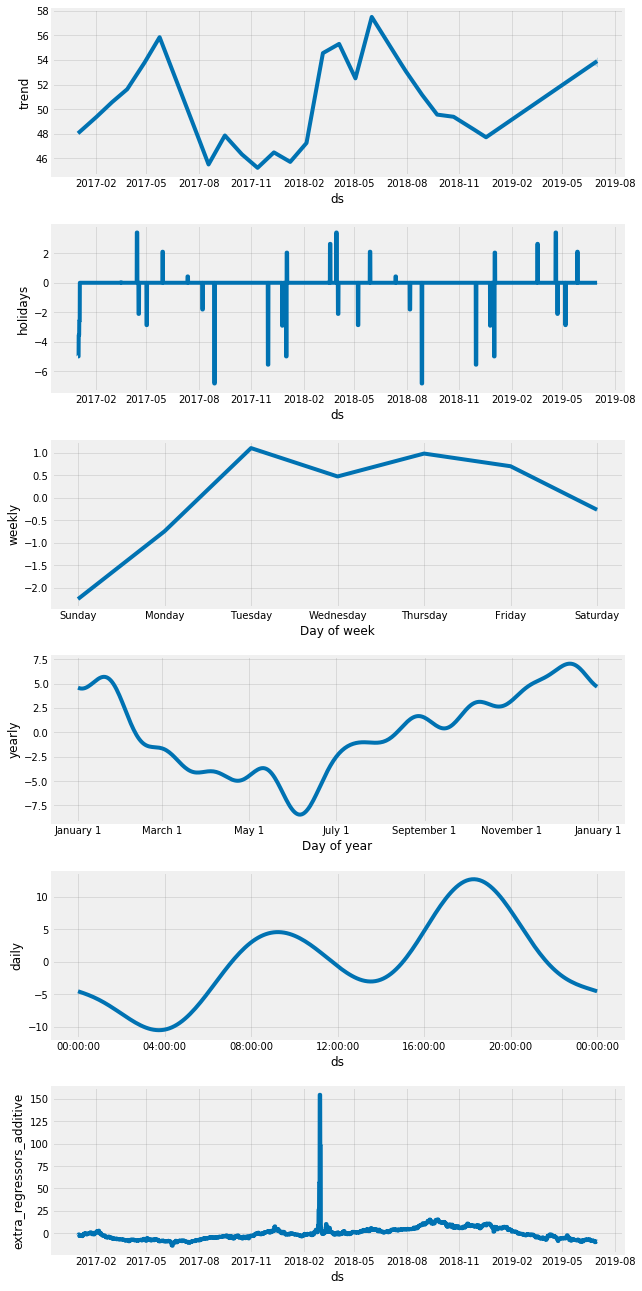

In [88]:
fig2 = model_P.plot_components(results_P) #Model Decomposition

In [89]:
#Prophet Model  evaluation:
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.metrics import mean_absolute_error

error1 = mse(test, forecast_P[train.shape[0]:])
error2 = rmse(test, forecast_P[train.shape[0]:])

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(true, pred):
    return 100/len(true) * np.sum(2 * np.abs(pred - true) / (np.abs(true) + np.abs(pred)))

print(f'MAE Error: {mean_absolute_error(test, forecast_P[train.shape[0]:])}'), 
print(f'MAPE Error: {mean_absolute_percentage_error(test, forecast_P[train.shape[0]:])}')
print(f'sMAPE Error: {smape(test, forecast_P[train.shape[0]:])}')
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
#print(forecast_P[train.shape[0]:].shape)
#print(test.shape)

MAE Error: 7.917195739456314
MAPE Error: 38.30689608266303
sMAPE Error: 20.12905441640181
MSE Error : 135.8272279
RMSE Error: 11.65449389


In [90]:
#Stationary Function
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [48]:
adf_test(df['Price'],'Stationarity test')

Augmented Dickey-Fuller Test: Stationarity test
ADF test statistic     -1.233837e+01
p-value                 6.198693e-23
# lags used             5.400000e+01
# observations          4.333600e+04
critical value (1%)    -3.430501e+00
critical value (5%)    -2.861607e+00
critical value (10%)   -2.566806e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [49]:
grangercausalitytests(df[['Price','INDO']],maxlag=3);
#this function is used to see if the time-series have inpact on each other 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=133.3429, p=0.0000  , df_denom=43387, df_num=1
ssr based chi2 test:   chi2=133.3521, p=0.0000  , df=1
likelihood ratio test: chi2=133.1476, p=0.0000  , df=1
parameter F test:         F=133.3429, p=0.0000  , df_denom=43387, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1635.9235, p=0.0000  , df_denom=43384, df_num=2
ssr based chi2 test:   chi2=3272.2240, p=0.0000  , df=2
likelihood ratio test: chi2=3154.7077, p=0.0000  , df=2
parameter F test:         F=1635.9235, p=0.0000  , df_denom=43384, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=954.5885, p=0.0000  , df_denom=43381, df_num=3
ssr based chi2 test:   chi2=2864.2276, p=0.0000  , df=3
likelihood ratio test: chi2=2773.6526, p=0.0000  , df=3
parameter F test:         F=954.5885, p=0.0000  , df_denom=43381, df_num=3


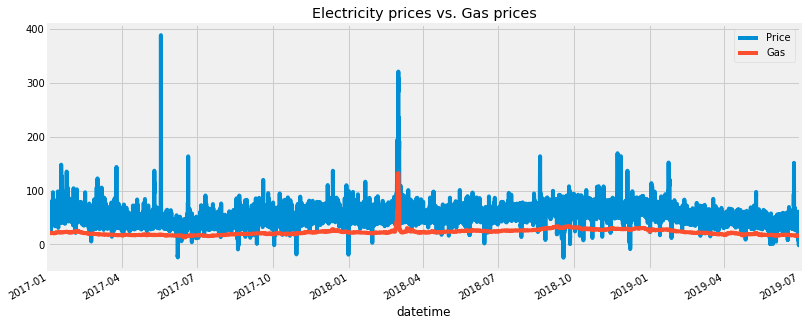

In [50]:
title = 'Electricity prices vs. Gas prices'
ylabel=''
xlabel=''

ax = df['Price'].plot(figsize=(12,5),title=title,legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Gas'].plot(legend=True);

[Text(0, 0.5, ''), Text(0.5, 0, '')]

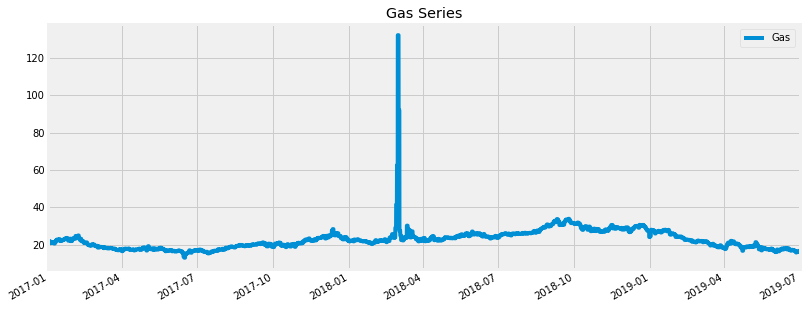

In [51]:
title = 'Gas Series'
ylabel=''
xlabel=''

ax = df['Gas'].plot(figsize=(12,5),title=title,legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
#df['Gas'].plot(legend=True);

[Text(0, 0.5, ''), Text(0.5, 0, '')]

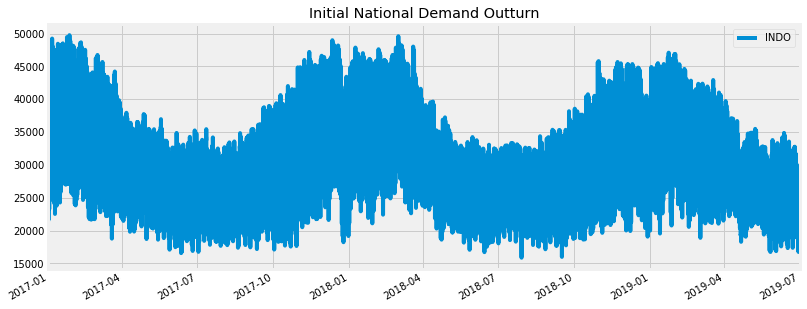

In [52]:
title = 'Initial National Demand Outturn'
ylabel=''
xlabel=''

ax = df['INDO'].plot(figsize=(12,5),title=title,legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

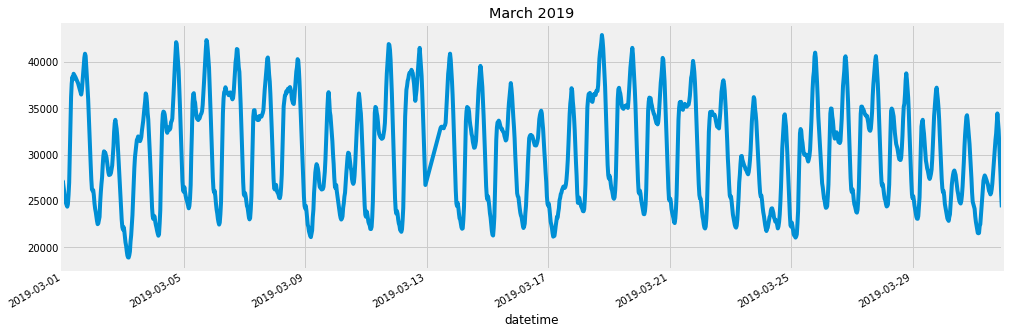

In [53]:
df['INDO'].loc[(df['INDO'].index >= '2019-03-01') &
               (df['INDO'].index < '2019-04-01')] \
    .plot(figsize=(15, 5), title = 'March 2019')

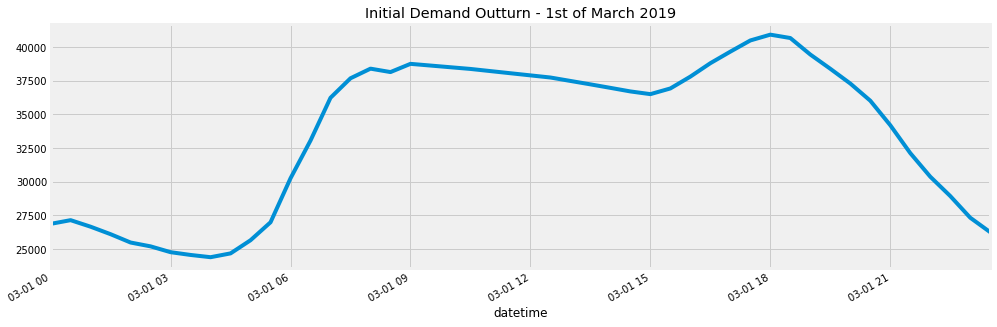

In [47]:
df['INDO'].loc[(df['INDO'].index >= '2019-03-01') &
               (df['INDO'].index < '2019-03-02')] \
    .plot(figsize=(15, 5), title = 'Initial Demand Outturn - 1st of March 2019')

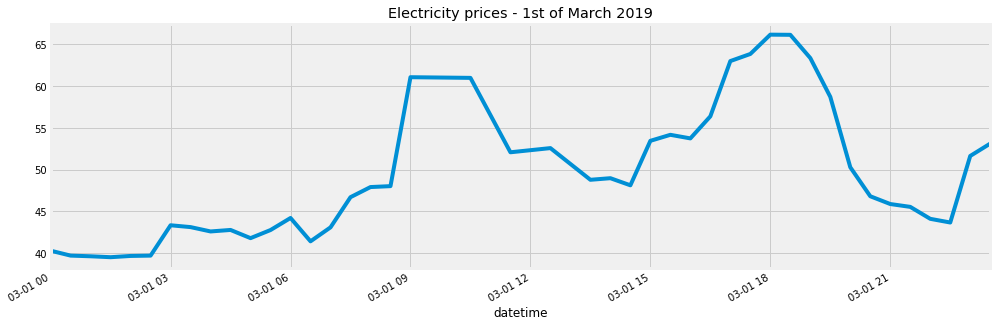

In [48]:
df['Price'].loc[(df['Price'].index >= '2019-03-01') &
               (df['Price'].index < '2019-03-02')] \
    .plot(figsize=(15, 5), title = 'Electricity prices - 1st of March 2019')

In [18]:
#Stationarity 
from statsmodels.tsa.seasonal import seasonal_decompose

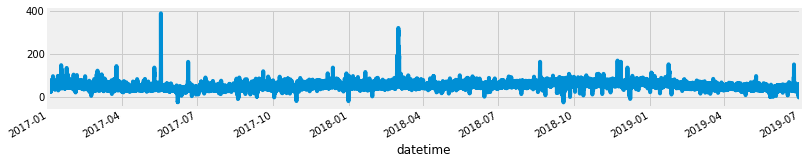

In [29]:
results = seasonal_decompose(df['Price'],freq=48)
results.observed.plot(figsize=(12,2))

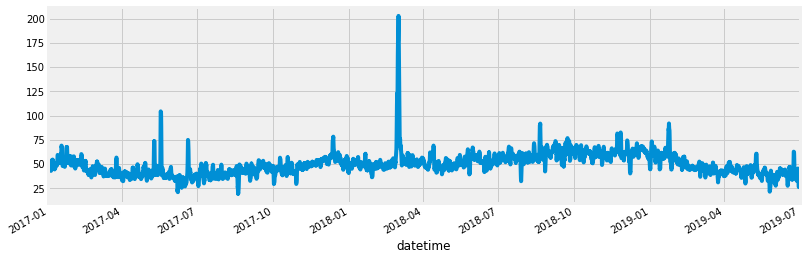

In [26]:
results.trend.plot(figsize=(12,4))

In [54]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree


In [93]:
df_train=df[df.index.isin(train.index)].copy()
df_test=df[df.index.isin(test.index)].copy()
df_train.shape,df_test.shape

((42575, 16), (768, 16))

In [94]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','Gas','INDO']]
    
    return X

In [95]:
X_train, y_train = create_features(df_train), df_train['Price']
X_test, y_test   = create_features(df_test), df_test['Price']

X_train.shape, y_train.shape, X_test.shape,y_test.shape

((42575, 10), (42575,), (768, 10), (768,))

In [96]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

[00:07:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

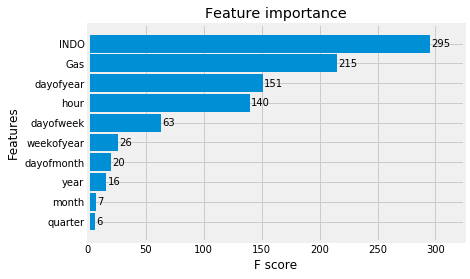

In [97]:
xgb.plot_importance(reg, height=0.9)

In [98]:
forecast_xgb= reg.predict(X_test)


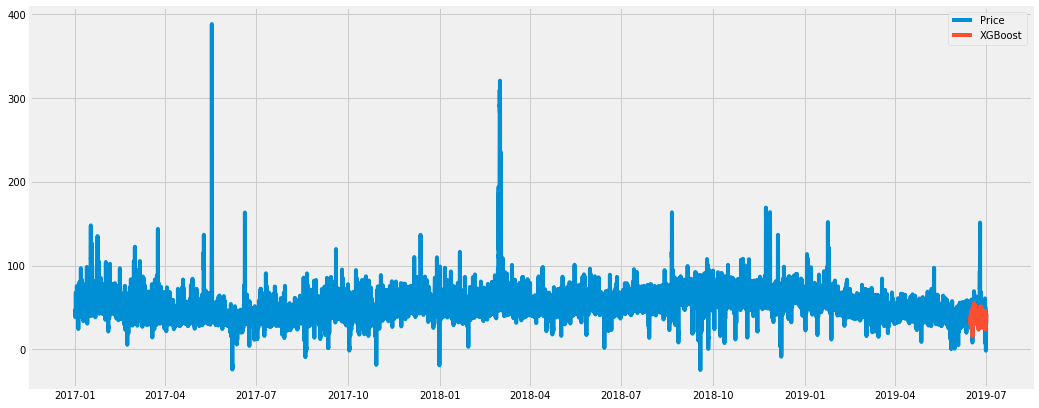

In [99]:
plt.figure(figsize=(16,7))
plt.plot(pd.concat([train,test]))
plt.plot(test.index, forecast_xgb, label='XGBoost')
plt.legend()

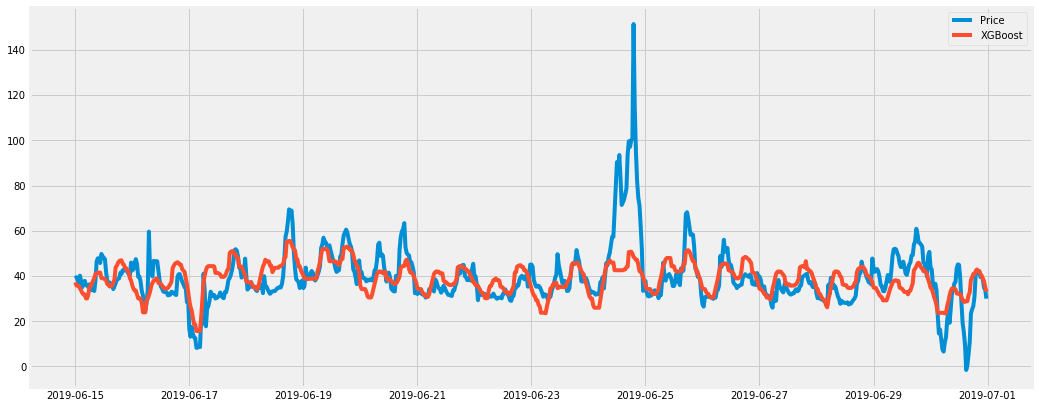

In [100]:
plt.figure(figsize=(16,7))
plt.plot(test)
plt.plot(test.index, forecast_xgb, label='XGBoost' )
plt.legend()

In [101]:
#Xgboost Model  evaluation:
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.metrics import mean_absolute_error

error1 = mse(test, forecast_xgb)
error2 = rmse(test, forecast_xgb)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(true, pred):
    return 100/len(true) * np.sum(2 * np.abs(pred - true) / (np.abs(true) + np.abs(pred)))


print(f'MAE Error: {mean_absolute_error(test, forecast_xgb)}'), 
print(f'MAPE Error: {mean_absolute_percentage_error(test, forecast_xgb)}')
print(f'sMAPE Error: {smape(test, forecast_xgb)}')
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print()

MAE Error: 6.61998319854339
MAPE Error: 27.72045884588838
sMAPE Error: 16.974476578227964
MSE Error : 110.5280509
RMSE Error: 10.51323218



In [102]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima # for determining ARIMA orders
%matplotlib inline
#ignore harmless warnings
import warnings 
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [103]:
#Arima model:
#SARIMAX with INDO:
model = SARIMAX(train,order=(5,1,1),seasonal_order=(1,0,1,12),
                exog=train_indo,
               enforce_stationarity=False,
               enforce_invertibility=False
               )
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Price   No. Observations:                42960
Model:             SARIMAX(5, 1, 1)x(1, 0, 1, 12)   Log Likelihood             -122625.425
Date:                            Fri, 27 Sep 2019   AIC                         245270.850
Time:                                    00:11:43   BIC                         245357.526
Sample:                                01-01-2017   HQIC                        245298.194
                                     - 06-14-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
INDO           0.0015    1.6e-05     95.372      0.000       0.001       0.002
ar.L1          0.0441      0.041      1.064      0.287      -0.037       0.125
ar.L2          0.0079      0.004      1.769      0.077      -0.001       0.017
ar.L3         -0.0198      0.002     -8.161      0.000      -0.025      -0.015
ar.L4         -0.0489      0.002    -27.235      0.000      -0.052      -0.045
ar.L5         -0.0748      0.004    -21.255      0.000      -0.082      -0.068
ma.L1          0.0434      0.041      1.052      0.293      -0.037       0.124
ar.S.L12       0.2319      0.055      4.183      0.000       0.123       0.341
ma.S.L12      -0.2837      0.055     -5.147      0.000      -0.392      -0.176
sigma2        17.7437      0.030    593.302      0.000      17.685      17.802
===================================================================================
Ljung-Box (Q):                     1244.94   Jarque-Bera (JB):          10294867.05
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                            -0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        78.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [104]:
test_indo=df_INDO[df_INDO.index.isin(test_indo.index)].copy()
test_indo[['INDO']].tail()

,INDO
datetime,
2019-06-30 21:30:00,25171
2019-06-30 22:00:00,25025
2019-06-30 22:30:00,23960
2019-06-30 23:00:00,21942
2019-06-30 23:30:00,20564


In [105]:
train_=df[df.index.isin(train.index)].copy()
train_[['Price']].shape

(42575, 1)

In [106]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast=test_indo[['INDO']]
predictions_sarima = results.predict(start=start,
                                     end=end,exog=exog_forecast,
                                     dynamic=False, typ='levels').rename('SARIMAX(5,1,1)(1,0,1,48) Predictions')

In [107]:
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.metrics import mean_absolute_error

error1 = mse(test, predictions_sarima)
error2 = rmse(test, predictions_sarima)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'MAE Error: {mean_absolute_error(test, predictions_sarima)}'), 
print(f'MAPE Error: {mean_absolute_percentage_error(test, predictions_sarima)}')
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print()

MAE Error: 7.49053245175713
MAPE Error: 33.38406371147807
MSE Error : 118.2716808
RMSE Error: 10.87527842



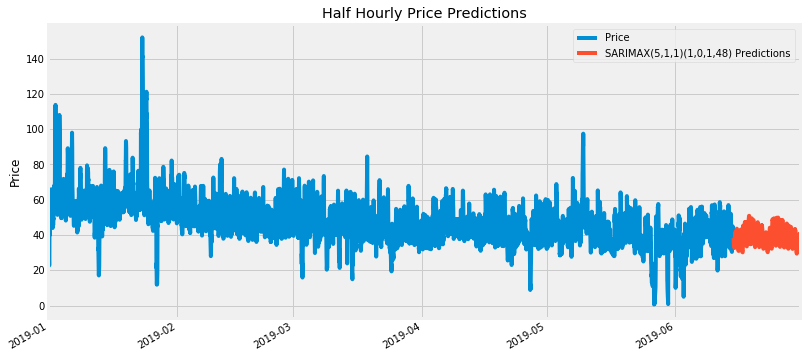

In [77]:
title = 'Half Hourly Price Predictions'
ylabel='Price'
xlabel='' 
ax = train_['Price'].plot(legend=True,figsize=(12,6),title=title)
predictions_sarima.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

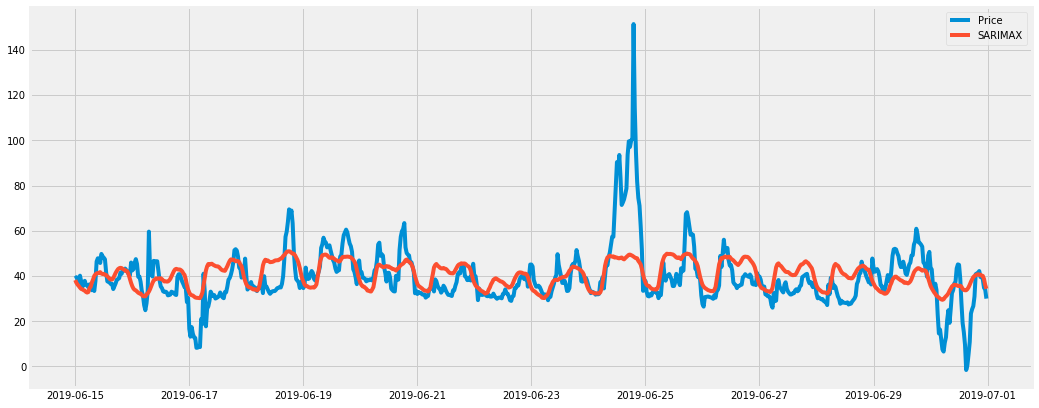

In [79]:
plt.figure(figsize=(16,7))
plt.plot(test)
plt.plot(test.index, predictions_sarima, label='SARIMAX')
plt.legend()